In [8]:
import csv
import os
from functools import partial
import json

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper
from gerrychain.proposals import recom, flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

import tqdm

In [9]:
unique_label = "GEOID10"
pop_col = "TOTPOP"
district_col = "CD"

plot_path = "./IA-shapefiles/IA_counties/IA_counties.shp"
graph = Graph.from_json("iowa.json")

In [10]:
df = gpd.read_file(plot_path)

In [11]:
def num_splits(partition):
    df["current"] = df[unique_label].map(dict(partition.assignment))
    splits = sum(df.groupby("COUNTYFP10")["current"].nunique() > 1)
    return splits

In [12]:
updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges, "black_pop": updaters.Tally("BPOP", alias = "black_pop"),
    "nh_white": updaters.Tally("NH_WHITE", alias = "nh_white"),
    "nh_black": updaters.Tally("NH_BLACK", alias = "nh_black"),
    "hisp": updaters.Tally("HISP", alias = "hisp"),
    "vap": updaters.Tally("VAP", alias = "vap"),
    "hvap": updaters.Tally("HVAP", alias = "hvap"),
    "wvap": updaters.Tally("WVAP", alias = "wvap"),
    "bvap":updaters.Tally("BVAP", alias = "bvap")
}

In [13]:
initial_partition = Partition(graph, "CD", updaters)

In [14]:
ideal_population = sum(initial_partition["population"].values()) / len(
    initial_partition)

In [15]:
proposal = partial(
    recom, pop_col="TOTPOP", pop_target=ideal_population, epsilon=0.02, node_repeats=2
)

In [16]:
def cut_length(partition):
    return len(partition["cut_edges"])

compactness_bound = constraints.UpperBound(
    cut_length, 2 * cut_length(initial_partition)
)

In [1]:
chain_length = 2

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.02),
        compactness_bound # single_flip_contiguous#no_more_discontiguous
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=chain_length,
)

pop = []
cut_edges = []
nh_white = []
nh_black = []
hisp = []
vap = []
hvap = []
wvap = []
bvap = []
splits = []
pop_metrics = {}

t = 0
for part in chain.with_progress_bar():
    splits.append(num_splits(part))
    pop.append(list(part["population"].values()))
    cut_edges.append(len(part["cut_edges"]))
    nh_white.append(list(part["nh_white"].values()))
    nh_black.append(list(part["nh_black"].values()))
    hisp.append(list(part["hisp"].values()))
    vap.append(list(part["vap"].values()))
    hvap.append(list(part["hvap"].values()))
    wvap.append(list(part["wvap"].values()))
    bvap.append(list(part["bvap"].values()))
    pop_metrics.update([("nh_white_pct", np.divide(nh_white,pop)), ("nh_black_pct",np.divide(nh_black, pop)), ("hisp_pct",np.divide(hisp, pop)), ("hvap_pct", np.divide(hvap, vap)), ("wvap_pct", np.divide(wvap, vap)), ("bvap_pct", np.divide(bvap, vap))])
    t += 1

NameError: name 'MarkovChain' is not defined

In [85]:
num_dist = 4
ideal_population = sum(initial_partition["population"].values()) / len(
    initial_partition)
random_plan = recursive_tree_part(graph, range(num_dist), ideal_population, "TOTPOP", 0.001, 1)
base_partition = Partition(graph, random_plan, updaters)
random_plan_2 = recursive_tree_part(graph, range(num_dist), ideal_population, "TOTPOP", 0.001, 1)
new_partition = Partition(graph, random_plan_2, updaters)

In [138]:
def greedy_hamming(base_partition, new_partition):
    names = [j for j in range(len(base_partition))]
    new_names = {}
    for i in range(num_dist):
        intersection_sizes = {}
        for name in names:
            intersection_sizes.update({len(set(base_partition.assignment.parts[name]).intersection(set(new_partition.assignment.parts[i]))): name})
        new_names.update({i: intersection_sizes[max(intersection_sizes.keys())]})
        names.remove(intersection_sizes[max(intersection_sizes.keys())])
    return new_names

In [123]:
def greedy_hamming_pop(base_partition, new_partition):
    names = [j for j in range(len(base_partition))]
    new_names = {}
    for i in range(len(base_partition)):
        intersections = {}
        intersection_pops = {}
        for name in names:
            intersections.update({name: set(base_partition.assignment.parts[name]).intersection(set(new_partition.assignment.parts[i]))})
            intersection_pops.update({sum([new_partition.graph.nodes[node]["TOTPOP"] for node in intersections[name]]): name})
        new_names.update({i: intersection_pops[max(intersection_pops.keys())]})
        names.remove(intersection_pops[max(intersection_pops.keys())])
    return new_names

In [139]:
greedy_hamming(base_partition, new_partition)

{0: 3, 1: 0, 2: 2, 3: 1}

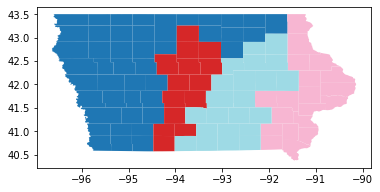

In [115]:
base_partition.plot(df, cmap = "tab20")

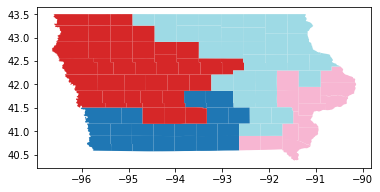

In [116]:
new_partition.plot(df, cmap = "tab20")

In [119]:
base_partition.graph.nodes[8]["TOTPOP"]

42745

In [129]:
new_partition.graph.number_of_nodes()

99